In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import json
import urllib.parse

%matplotlib inline
ox.__version__

'1.3.0'

## Set boundary

In [4]:
portland_boundary = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_Town_and_Townships_Boundary_Polygons_Dissolved/FeatureServer/0/query?where=TOWN%20%3D%20'PORTLAND'&outFields=*&outSR=32619&f=json")

## Load census tracts

In [5]:
tracts = gpd.read_file("data/tl_2022_23_tract.zip").set_index('GEOID').to_crs('EPSG:32619').clip(portland_boundary)

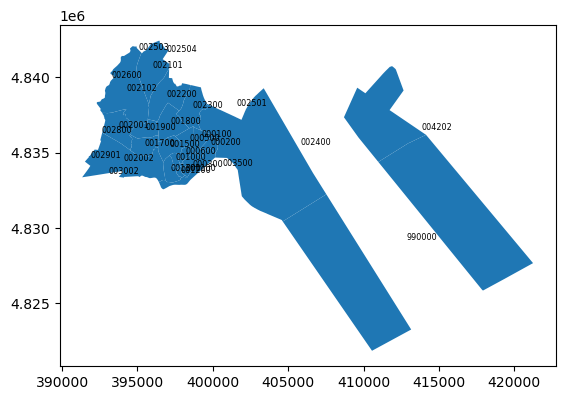

In [6]:
ax = tracts.plot()
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})

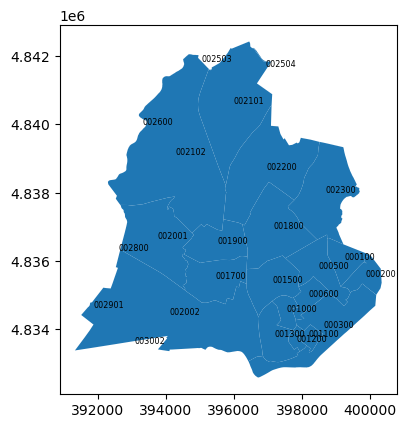

In [7]:
# manually remove islands
tracts = tracts.drop(['23005990000', '23005004202', '23005002400', '23005003500', '23005002501'])
ax = tracts.plot()
for geoid in tracts.index:
    x, y = tracts.loc[geoid]['geometry'].centroid.xy
    ax.text(x[0], y[0], geoid[5:], fontdict={'fontsize':'xx-small'})

## Load Conserved Lands based on bounding box

In [8]:
# make an ESRI geometry JSON object from the bounding box
# https://developers.arcgis.com/rest/services-reference/enterprise/query-map-service-layer-.htm
bbox_json = json.dumps({"points":tracts.geometry.envelope[0].exterior.coords[:]})
bbox_json

'{"points": [[397597.2300370693, 4833334.762044658], [398131.86816808424, 4833334.762044658], [398131.86816808424, 4833949.21302991], [397597.2300370693, 4833949.21302991], [397597.2300370693, 4833334.762044658]]}'

<AxesSubplot: >

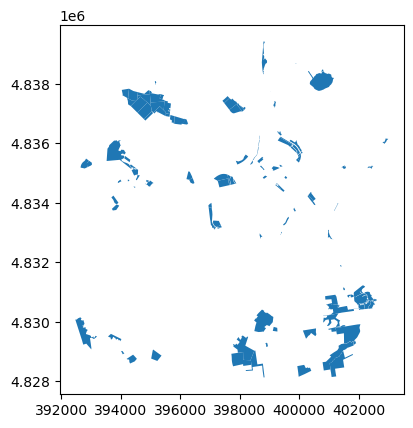

In [9]:
# get all conserved parcels within 3 mile radius of this polygon
lands = gpd.read_file("https://gis.maine.gov/arcgis/rest/services/acf/Conserved_Lands/MapServer/0/query?"+
                      "where=&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry="+
                      urllib.parse.quote(bbox_json)+
                      "&geometryType=esriGeometryMultipoint&inSR=32619&spatialRel=esriSpatialRelEnvelopeIntersects&"+
                      "distance="+str(3)+"&units=esriSRUnit_StatuteMile&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=32619&havingClause=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&sqlFormat=none&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson")
lands.plot()

## Download and prep the street network

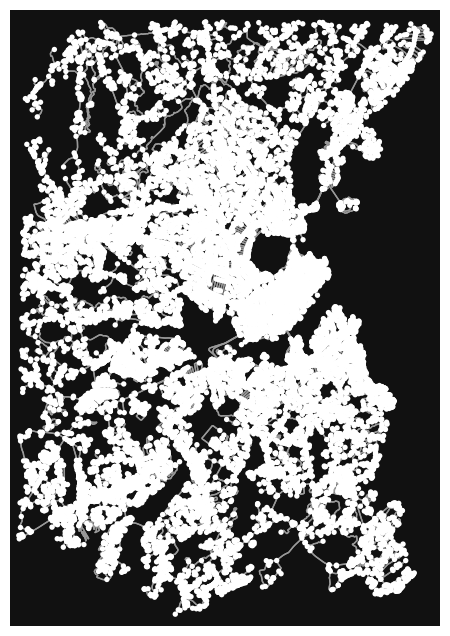

<AxesSubplot: >

<Figure size 640x480 with 0 Axes>

In [13]:
# # download the street network
# bbox = lands.to_crs("EPSG:4326").geometry.unary_union.envelope.bounds
# buffer = 0.05
# network_type = "walk"
# G = ox.graph_from_bbox(bbox[3]+buffer, bbox[1]-buffer, bbox[2]+buffer, bbox[0]-buffer, network_type=network_type)
# or load from file
filepath = "./data/greater_portland.graphml"
G = ox.load_graphml(filepath)

G = ox.project_graph(G, 'EPSG:32619') # project the graph to UTM for this zone

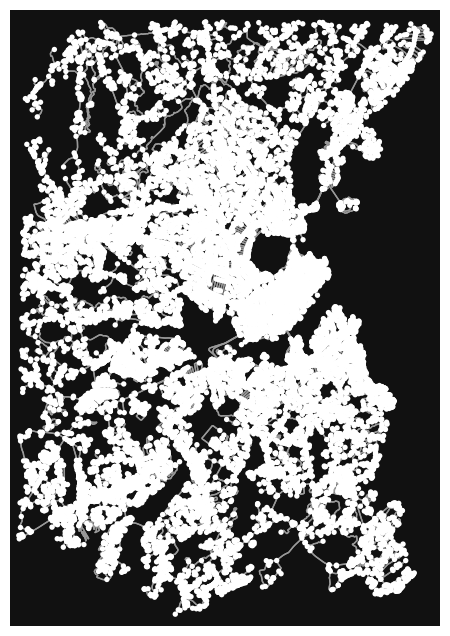

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [21]:
ox.plot_graph(G)


In [22]:
filepath = "./data/greater_portland.graphml"
ox.save_graphml(G, filepath)

Median Distance:  52 ft


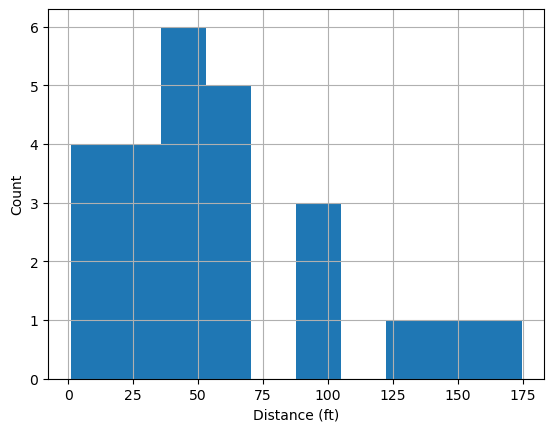

In [48]:
# find census tract centroids
centroids = [point.xy for point in tracts.centroid]
# Find the nearest node to the centroid
center_nodes = [ox.distance.nearest_nodes(G, x[0], y[0]) for x, y in centroids]
center_nodes_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes]

# verify that nodes are reasonably close
dists = center_nodes_gdf.distance(tracts.centroid, align=False)
ax = dists.hist()
ax.set_xlabel("Distance (ft)")
ax.set_ylabel("Count")
print("Median Distance: {:3.0f} ft".format(dists.median()))

## Plot nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [24]:
# configure trip times and travel speed
trip_times = [5, 10, 15, 20, 30, 45, 60]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [25]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [26]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

Plotting node 101625302


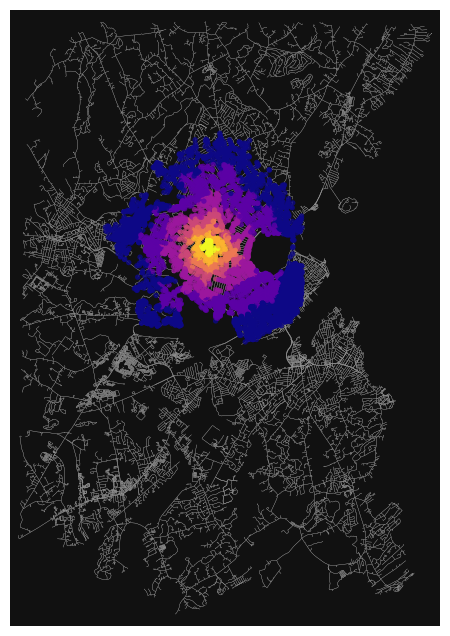

In [27]:
center_node = center_nodes[18]
print("Plotting node {}".format(center_node))
# color the nodes according to isochrone then plot the street network
node_times = {}
node_colors = {}
# loop over allowed trip times
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    # find subgraph from center node
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    # color nodes according to the isoline
    for node in subgraph.nodes():
        node_times[node] = trip_time
        node_colors[node] = color
# set node size and color for unreachable nodes
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
# show the result
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

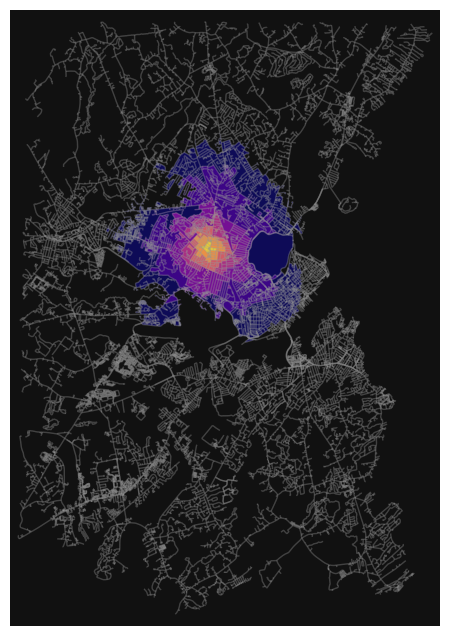

In [28]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=5, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame.from_dict({"trip_times":trip_times, "geometry":isochrone_polys}, crs="EPSG:32619")

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

## Identify Conserved Lands within Isochrones

In [29]:
# find conserved land centroids
centroids_cl = [point.xy for point in lands.centroid]
# Find the nearest node to the centroid
center_nodes_cl = [ox.distance.nearest_nodes(G, x[0], y[0]) for x, y in centroids_cl]
center_nodes_cl_gdf = ox.graph_to_gdfs(G, edges=False).loc[center_nodes_cl]

Median Distance:  53 ft


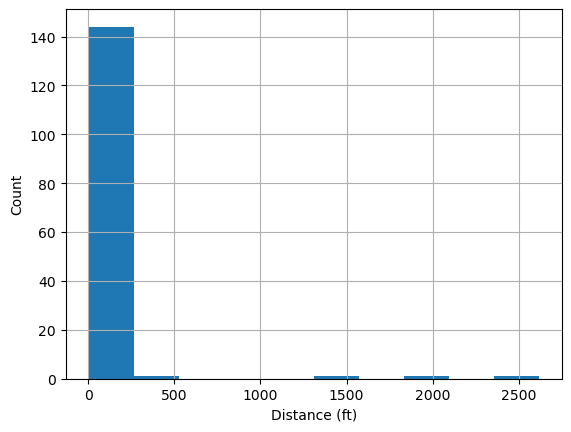

In [47]:
# verify that nodes are reasonably close
dists = center_nodes_cl_gdf.distance(lands.centroid, align=False)
ax = dists.hist()
ax.set_xlabel("Distance (ft)")
ax.set_ylabel("Count")
print("Median Distance: {:3.0f} ft".format(dists.median()))

In [31]:
# create a dataframe with the points
times = [node_times[node] if node in node_times else None for node in center_nodes_cl]
lands_points = lands.copy()
lands_points["geometry"] = center_nodes_cl_gdf.reset_index()["geometry"]
lands_points["trip_times"] = times
lands_colors = [node_colors[node] if node in node_colors else "none" for node in center_nodes_cl]

In [32]:
# calculate the number of lands within each trip time
lands_points.groupby("trip_times")["OBJECTID"].count()

trip_times
10.0     3
15.0     5
20.0     6
30.0     9
45.0    19
60.0    25
Name: OBJECTID, dtype: int64

In [51]:
lands_points.columns

Index(['OBJECTID', 'PROJECT', 'PARCEL_NAME', 'DESIGNATION', 'CONS1_TYPE',
       'HOLD1_NAME', 'HOLD1_TYPE', 'CONS2_TYPE', 'HOLD2_NAME', 'HOLD2_TYPE',
       'ECO_RESERVE', 'ACQ_YEAR', 'ACQ_DATE', 'RPT_AC', 'CALC_AC',
       'PUB_ACCESS', 'PURPOSE1', 'PURPOSE2', 'BPL_ID', 'IFW_ID', 'LMF_ID',
       'DEPT_ID', 'NOTE_', 'GAP_STATUS', 'IUCN_STATUS', 'CL_UNIQUEID',
       'TAX_MAP_TOWN', 'TAX_MAP_BOOK_LOT', 'geometry', 'trip_times'],
      dtype='object')

In [54]:
lands_points.groupby("trip_times")["CALC_AC"].sum()

trip_times
10.0     28.083650
15.0     44.625488
20.0    147.134227
30.0     72.280626
45.0    211.292286
60.0     77.662259
Name: CALC_AC, dtype: float64

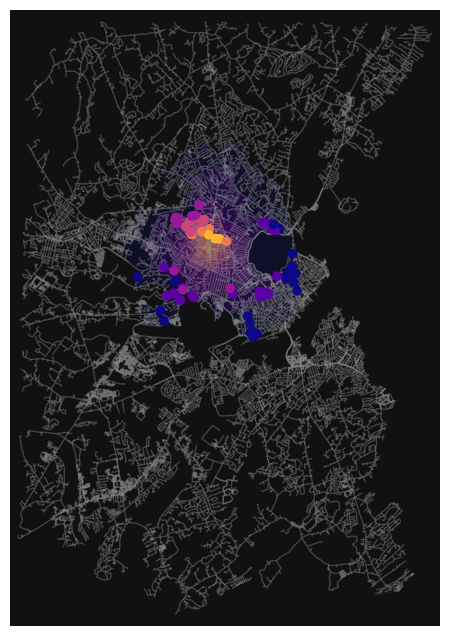

In [50]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.2, zorder=-1)
lands_points.plot(ax=ax, color=lands_colors)
plt.show()

In [35]:
# list properties within a 10 minute walk
lands_points[lands_points["trip_times"] == 10]

,OBJECTID,PROJECT,PARCEL_NAME,DESIGNATION,CONS1_TYPE,HOLD1_NAME,HOLD1_TYPE,CONS2_TYPE,HOLD2_NAME,HOLD2_TYPE,...,LMF_ID,DEPT_ID,NOTE_,GAP_STATUS,IUCN_STATUS,CL_UNIQUEID,TAX_MAP_TOWN,TAX_MAP_BOOK_LOT,geometry,trip_times
89,8014,NaN,135 A005,Miscellaneous Municipal Lands,Fee,Maine Minor Civil Division,Municipal,NaN,NaN,NaN,...,NaN,NaN,copied city lands (JRS),4-Unsecured (temporary easements lands and/or ...,NaN,10500,NaN,NaN,POINT (395781.441 4836825.407),10.0
125,6509,NaN,136 D004,Miscellaneous Municipal Lands,Fee,Maine Minor Civil Division,Municipal,NaN,NaN,NaN,...,NaN,NaN,copied city lands (JRS),4-Unsecured (temporary easements lands and/or ...,NaN,10613,NaN,NaN,POINT (395933.932 4836821.699),10.0
141,4963,NaN,134 F001,Miscellaneous Municipal Lands,Fee,Maine Minor Civil Division,Municipal,NaN,NaN,NaN,...,NaN,NaN,copied city lands (JRS),4-Unsecured (temporary easements lands and/or ...,NaN,10624,NaN,NaN,POINT (395530.745 4836973.581),10.0
